In [887]:
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
import random 
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Problem + Significance

Website outages, often referred to as downtime, can have a detrimental impact on an organization’s revenue and reputation. Conversely, optimizing uptime towards near perfection can be costly in terms of investment and resources. The tradeoffs will be weighed by whether the organization can expect uptime to be above or below the generally acceptable SLA level of 99.9% (three nines). If the simulations demonstrate at least 99.9% uptime -- equates to 43m 49s monthly -- can be expected, the organization will continue to run their website on one server. If the simulations show an uptime under 99.9% can be expected, the company will proceed with setting up a web farm (distributing traffic across two or more servers).

## Flow Chart

![Simulation Flow Diagram](sim-flow-chart.png)

## Params

In [805]:
SIMULATION_MIN = 1440 * 7 # Length of simulation
QUEUE_CAP = 10000 # Queue capacity, if exceeded an outage occurs
REQS_PER_MIN = 700 # Baseline requests per minute we expect
RPM_SD = 200 # Standard deviation for requests per minute
REQS_RESP_PER_MIN = 2000 # Baseline requests the server can respond to per minute
RRPM_SD = 200 # Standard deviation for requests per minute
DOWNTIME_MIN = 10 # Downtime minutes when outage occurs

MK_START = 0 # Start of marketing campaign (zero is equivalent to midnight Monday)
MK_END = 4320 # Start of marketing campaign (zero is equivalent to 11:59 Friday)
MK_REQS_NUM = 100 # Avg. requests per minute from marketing campaign

BOT_PROB = 0.05 # Probability of bot attack
BOT_REQS_NUM = 900 # Requests per minute from bot attack
BOT_EFFECT_MIN = 5 # Length of bot attack in minutes

PR_PROB = 0.02 # Probability of press
PR_REQS_NUM = 1100 # Requests per minute from press
PR_EFFECT_MIN = 10 # Length of bot attack in minutes

## Simulation Code

In [871]:
def get_time_of_day(time_of_day_counter):
    """Determine whether it is night, morning or afternoon
    
    Params:
        time_of_day_counter - tracks what minute of the day it is currently
    Returns:
        tuple with multiplier for what time of day it is
    """
    # 8:01pm until 6am
    if time_of_day_counter > 1200 or time_of_day_counter < 301:
        time_of_day = ("Night", .9)
    # 6:01am until 12pm
    elif time_of_day_counter > 300 and time_of_day_counter < 721:
        time_of_day = ("Morning", 1)
    # 12:01pm until 8pm
    elif time_of_day_counter > 720 and time_of_day_counter < 1201:
        time_of_day = ("Afternoon", 1.3)
    return time_of_day

def get_day_of_week(day_of_week_counter):
    """Determine whether it is a weekday (Mon-Fri) or weekend (Sat-Sun)
    
    Params:
        day_of_week_counter - tracks what minute of the week it is currently
    Returns:
        tuple with multiplier for weekday or weekend
    """
    # 0 to 7200 represents minutes between Monday and Friday
    if day_of_week_counter < 7201:
        day_of_week = ("Weekday", 1)
    # Greater than 7200 represents minutes between Saturday and Sunday
    elif day_of_week_counter > 7200:
        day_of_week = ("Weekend!", 0.6)
    return day_of_week

def get_marketing_campaign(day_of_week_counter, time_of_day, mk_start, mk_end, mk_reqs_num):
    """Determine whether a marketing campaign is live
    
    Params:
        day_of_week_counter - tracks what minute of the week it is currently
        time_of_day - (str) tracks whether it is "Night", "Morning", "Afternoon"
        mk_start - start minute of the marketing campaign (e.g. 0 = Monday at midnight)
        mk_end - end minute of the marketing campaign (e.g. 4320 = Wednesday at 11:59pm)
        mk_reqs_num - static number of requests to be added to the requests per minute total
    
    Returns:
        static number of requests to be added to the requests per minute total
    """
    if day_of_week_counter > mk_start and day_of_week_counter < mk_end and time_of_day == "Afternoon":
        mk_requests = mk_reqs_num
    else:
        mk_requests = 0
    return mk_requests

def get_attack_of_the_bots(bot_prob, bot_reqs_num):
    """Determine if a bot attack is occuring
    
    Params:
        bot_prob - probability of a bot attack occuring
        bot_reqs_num - static number of requests to be added to the requests per minute total
        
    Returns:
        static number of requests to be added to the requests per minute total
    """
    if np.random.binomial(1, bot_prob):
        bot_requests = bot_reqs_num
    else:
        bot_requests = 0
    return bot_requests

def get_national_press(pr_prob, pr_reqs_num):
    """Determine whether the website is seeing an increase in traffic due to press
    
    Params:
        pr_prob - probability of noteworthy press occuring
        pr_reqs_num - static number of requests to be added to the requests per minute total
    Returns:
        static number of requests to be added to the requests per minute total
    """
    if np.random.binomial(1, pr_prob):
        press_requests = pr_reqs_num
    else:
        press_requests = 0
    return press_requests

def server_sim(sim_min, queue_cap, requests_per_min, rpm_sd, reqs_resp_per_min, rrpm_sd, downtime_min, 
               mk_start, mk_end, mk_reqs_num, bot_prob, bot_reqs_num, bot_effect_min, pr_prob, 
               pr_reqs_num, pr_effect_min):
    """Performs simulation of server uptime. Each loop represents one minute.
    
    Params:
        sim_min - number of minutes to simulate
        queue_cap - server capacity. if the queue exceeds this amount downtime occurs
        requests_per_min - baseline requests per minute, which is later modified by several factors
        rpm_sd - requests_per_min standard deviation
        reqs_resp_per_min - baseline requests per minute the server can respond to
        rrpm_sd - reqs_resp_per_min standard deviation
        downtime_min - when downtime occurs, this is the number of minutes to add to downtime total
        bot_effect_min - if a bot attack occurs, the number of minutes it should last
        pr_effect_min - if a press event occurs, the number of minutes it should last
    
    Returns:
        pandas dataframe capturing - Minute, Req_Queue, Downtime, Downtime_Min and more
    """
    downtime_counter = 0
    request_queue = 0
    time_of_day_counter = 1
    day_of_week_counter = 1
    pr_counter = 0
    bot_counter = 0
    i = 1
            
    df_sim = pd.DataFrame(columns = ['Minute', 'Req_Queue', 'Req_Mod', 'Time_of_Day', 
                                     'Day_of_Week', 'Req_MK', 'Req_Bots', 'Req_PR', 
                                     'Req_Orig', 'Downtime', 'Downtime_Min'])
    while i <= sim_min:
        if request_queue < 0:
            request_queue = 0
                
        time_of_day = get_time_of_day(time_of_day_counter)
        day_of_week = get_day_of_week(day_of_week_counter)
        mk_reqs = get_marketing_campaign(day_of_week_counter, time_of_day[0], mk_start, mk_end, mk_reqs_num)
        bot_reqs = get_attack_of_the_bots(bot_prob, bot_reqs_num)
        pr_reqs = get_national_press(pr_prob, pr_reqs_num)

        # If a press event has occured, initiate pr_counter with the number of minutes
        # the event should last for
        if pr_reqs > 0:
            pr_counter = pr_effect_min

        # If a press event has occured, initiate pr_reqs with the number of requests
        # that should be added to the baseline requests per minute
        if pr_counter > 0:
            pr_reqs = pr_reqs_num

        # If a bot attack has occured, initiate bot_counter with the number of minutes
        # the attack should last for
        if bot_reqs > 0:
            bot_counter = bot_effect_min

        # If a bot attack has occured, initiate bot_reqs with the number of requests
        # that should be added to the baseline requests per minute
        if bot_counter > 0:
            bot_reqs = bot_reqs_num
                
        # Generate the baseline number of requests for this minute
        avg_req_min = np.random.normal(requests_per_min, rpm_sd, 1)[0]
        
        # Modify number of requests by time of day, day of week, and other factors
        avg_req_min_mod = avg_req_min * time_of_day[1] * day_of_week[1] + mk_reqs + bot_reqs + pr_reqs
  
        # Increment request queue
        request_queue += avg_req_min_mod
        
        # Check for overcapacity and assign overcapacity variable for dataframe
        overcapacity = 1 if request_queue > queue_cap else 0
        
        # Append current state to dataframe
        df_sim = df_sim.append({'Minute' : i, 'Req_Queue' : request_queue, 'Req_Mod' : avg_req_min_mod,
                                'Time_of_Day' : time_of_day[0], 'Day_of_Week' : day_of_week[1], 
                                'Req_MK' : mk_reqs, 'Req_Bots' : bot_reqs, 'Req_PR' : pr_reqs, 
                                'Req_Orig' : avg_req_min, 'Downtime' : (request_queue > 10000),
                                'Downtime_Min' : overcapacity}, ignore_index = True)
         
        # 1440 is number of minutes in a day
        if time_of_day_counter == 1440:
            time_of_day_counter = 0
        
        # 10080 is number of minutes in a week
        if day_of_week_counter == 10080:
            day_of_week_counter = 0
        
        # Check for overcapacity and take appropriate actions
        if request_queue > queue_cap:
            print("DOWNTIME!")
            i += 1
            for dt_inc in range(downtime_min-1):
                df_sim = df_sim.append({'Minute' : i, 'Req_Queue' : request_queue, 'Req_Mod' : avg_req_min_mod,
                                'Time_of_Day' : time_of_day[0], 'Day_of_Week' : day_of_week[1], 
                                'Req_MK' : mk_reqs, 'Req_Bots' : bot_reqs, 'Req_PR' : pr_reqs, 
                                'Req_Orig' : avg_req_min, 'Downtime' : False,
                                'Downtime_Min' : overcapacity}, ignore_index = True)
                i += 1
                downtime_counter += 1
            time_of_day_counter += downtime_min
            day_of_week_counter += downtime_min
            request_queue = 0
            pr_counter = 0
            bot_counter = 0
            continue
        
        # Removing the number of requests the server was able to respond to this minute
        request_queue -= np.random.normal(reqs_resp_per_min, rrpm_sd, 1)[0]
        
        pr_counter -=1
        bot_counter -=1
        time_of_day_counter +=1
        day_of_week_counter +=1
        i += 1
        
    return df_sim


## Simulating 4 Weeks

### Week 1

In [876]:
np.random.seed(1)
df_sim_week_1 = server_sim(SIMULATION_MIN, QUEUE_CAP, REQS_PER_MIN, RPM_SD, REQS_RESP_PER_MIN, RRPM_SD, 
                              DOWNTIME_MIN, MK_START, MK_END, MK_REQS_NUM, BOT_PROB, BOT_REQS_NUM, BOT_EFFECT_MIN,
                              PR_PROB, PR_REQS_NUM, PR_EFFECT_MIN)

print("Downtime minutes: ", sum(df_sim_week_1["Downtime_Min"]))
print("Total outages: ", sum(df_sim_week_1["Downtime"]) / 10)
print("Uptime %: ", 1 - (sum(df_sim_week_1["Downtime_Min"]) / df_sim_week_1["Minute"][-1:].values[0]))

DOWNTIME!
DOWNTIME!
Downtime minutes:  20
Total outages:  0.2
Uptime %:  0.998015873015873


In [858]:
df_sim_week_1.shape

(10080, 11)

### Week 2

In [873]:
np.random.seed(2)
df_sim_week_2 = server_sim(SIMULATION_MIN, QUEUE_CAP, REQS_PER_MIN, RPM_SD, REQS_RESP_PER_MIN, RRPM_SD, 
                              DOWNTIME_MIN, MK_START, MK_END, MK_REQS_NUM, BOT_PROB, BOT_REQS_NUM, BOT_EFFECT_MIN,
                              PR_PROB, PR_REQS_NUM, PR_EFFECT_MIN)

print("Downtime minutes: ", sum(df_sim_week_2["Downtime_Min"]))
print("Total outages: ", sum(df_sim_week_2["Downtime"]))
print("Uptime %: ", 1 - (sum(df_sim_week_2["Downtime_Min"]) / df_sim_week_2["Minute"][-1:].values[0]))

DOWNTIME!
DOWNTIME!
DOWNTIME!
DOWNTIME!
Downtime minutes:  40
Total outages:  4
Uptime %:  0.996031746031746


In [860]:
df_sim_week_2.shape

(10080, 11)

### Week 3

In [875]:
np.random.seed(30)
df_sim_week_3 = server_sim(SIMULATION_MIN, QUEUE_CAP, REQS_PER_MIN, RPM_SD, REQS_RESP_PER_MIN, RRPM_SD, 
                              DOWNTIME_MIN, MK_START, MK_END, MK_REQS_NUM, BOT_PROB, BOT_REQS_NUM, BOT_EFFECT_MIN,
                              PR_PROB, PR_REQS_NUM, PR_EFFECT_MIN)

print("Downtime minutes: ", sum(df_sim_week_3["Downtime_Min"]))
print("Total outages: ", sum(df_sim_week_3["Downtime"]))
print("Uptime %: ", 1 - (sum(df_sim_week_3["Downtime_Min"]) / df_sim_week_3["Minute"][-1:].values[0]))

DOWNTIME!
DOWNTIME!
DOWNTIME!
Downtime minutes:  30
Total outages:  3
Uptime %:  0.9970238095238095


In [862]:
df_sim_week_3.shape

(10080, 11)

### Week 4

In [867]:
np.random.seed(4) 
df_sim_week_4 = server_sim(SIMULATION_MIN, QUEUE_CAP, REQS_PER_MIN, RPM_SD, REQS_RESP_PER_MIN, RRPM_SD, 
                              DOWNTIME_MIN, MK_START, MK_END, MK_REQS_NUM, BOT_PROB, BOT_REQS_NUM, BOT_EFFECT_MIN,
                              PR_PROB, PR_REQS_NUM, PR_EFFECT_MIN)

print("Downtime minutes: ", sum(df_sim_week_4["Downtime_Min"]))
print("Total outages: ", sum(df_sim_week_4["Downtime"]))
print("Uptime %: ", 1 - (sum(df_sim_week_4["Downtime_Min"]) / df_sim_week_4["Minute"][-1:].values[0]))

DOWNTIME!
DOWNTIME!
Downtime minutes:  20
Total outages:  2
Uptime %:  0.998015873015873


In [864]:
df_sim_week_4.shape

(10080, 11)

## Preview Minute-Level Events of Week 1 Simulation

In [790]:
# Preview the beginning of the simulation
df_sim_week_1.head(20)

,Minute,Req_Queue,Req_Mod,Time_of_Day,Day_of_Week,Req_MK,Req_Bots,Req_PR,Req_Orig,Downtime,Downtime_Min
0,1,828.275690,828.275690,Night,1,0,0,0,920.306323,False,0
1,2,461.750849,461.750849,Night,1,0,0,0,513.056499,False,0
2,3,618.240154,618.240154,Night,1,0,0,0,686.933504,False,0
3,4,590.558004,590.558004,Night,1,0,0,0,656.175561,False,0
4,5,834.758756,834.758756,Night,1,0,0,0,927.509729,False,0
5,6,666.636664,666.636664,Night,1,0,0,0,740.707405,False,0
6,7,767.813361,767.813361,Night,1,0,0,0,853.125956,False,0
7,8,382.595570,382.595570,Night,1,0,0,0,425.106189,False,0
8,9,607.861147,607.861147,Night,1,0,0,0,675.401274,False,0
9,10,795.503654,795.503654,Night,1,0,0,0,883.892949,False,0


In [791]:
# Preview the middle of the simulation
midday = int(df_sim_week_1.shape[0] / 2)
df_sim_week_1[midday:midday+20]

,Minute,Req_Queue,Req_Mod,Time_of_Day,Day_of_Week,Req_MK,Req_Bots,Req_PR,Req_Orig,Downtime,Downtime_Min
5040,5041,1098.877143,1098.877143,Afternoon,1,0,0,0,845.290110,False,0
5041,5042,709.966450,709.966450,Afternoon,1,0,0,0,546.128039,False,0
5042,5043,1002.986165,1002.986165,Afternoon,1,0,0,0,771.527819,False,0
5043,5044,512.915480,512.915480,Afternoon,1,0,0,0,394.550369,False,0
5044,5045,752.732471,752.732471,Afternoon,1,0,0,0,579.024977,False,0
5045,5046,532.706416,532.706416,Afternoon,1,0,0,0,409.774166,False,0
5046,5047,1025.935820,1025.935820,Afternoon,1,0,0,0,789.181400,False,0
5047,5048,1003.446032,1003.446032,Afternoon,1,0,0,0,771.881563,False,0
5048,5049,382.249160,382.249160,Afternoon,1,0,0,0,294.037815,False,0
5049,5050,840.917461,840.917461,Afternoon,1,0,0,0,646.859585,False,0


In [792]:
# Preview the end of the simulation
df_sim_week_1.tail(20)

,Minute,Req_Queue,Req_Mod,Time_of_Day,Day_of_Week,Req_MK,Req_Bots,Req_PR,Req_Orig,Downtime,Downtime_Min
10060,10061,476.797678,476.797678,Night,0.6,0,0,0,882.958662,False,0
10061,10062,617.086271,617.086271,Night,0.6,0,0,0,1142.752353,False,0
10062,10063,382.119527,382.119527,Night,0.6,0,0,0,707.628754,False,0
10063,10064,151.797288,151.797288,Night,0.6,0,0,0,281.106089,False,0
10064,10065,532.515095,532.515095,Night,0.6,0,0,0,986.139065,False,0
10065,10066,311.009158,311.009158,Night,0.6,0,0,0,575.942885,False,0
10066,10067,369.338042,369.338042,Night,0.6,0,0,0,683.959337,False,0
10067,10068,512.248695,512.248695,Night,0.6,0,0,0,948.608694,False,0
10068,10069,507.705389,507.705389,Night,0.6,0,0,0,940.195164,False,0
10069,10070,1135.280130,1135.280130,Night,0.6,0,900,0,435.703944,False,0


## Convert Minutes to Datetime Data Type

In [793]:
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

feb_wk_1 = [dt.strftime('%m-%d-%y %H:%M') for dt in 
            datetime_range(datetime(2021, 2, 1, 0), datetime(2021, 2, 8, 0), 
            timedelta(minutes=1))]

feb_wk_2 = [dt.strftime('%m-%d-%y %H:%M') for dt in 
            datetime_range(datetime(2021, 2, 8, 0), datetime(2021, 2, 15, 0), 
            timedelta(minutes=1))]

feb_wk_3 = [dt.strftime('%m-%d-%y %H:%M') for dt in 
            datetime_range(datetime(2021, 2, 15, 0), datetime(2021, 2, 22, 0), 
            timedelta(minutes=1))]

feb_wk_4 = [dt.strftime('%m-%d-%y %H:%M') for dt in 
            datetime_range(datetime(2021, 2, 22, 0), datetime(2021, 3, 1, 0), 
            timedelta(minutes=1))]

In [794]:
df_sim_week_1["time"] = feb_wk_1
df_sim_week_2["time"] = feb_wk_2
df_sim_week_3["time"] = feb_wk_3
df_sim_week_4["time"] = feb_wk_4

## Visualize Queue Volume Over Time

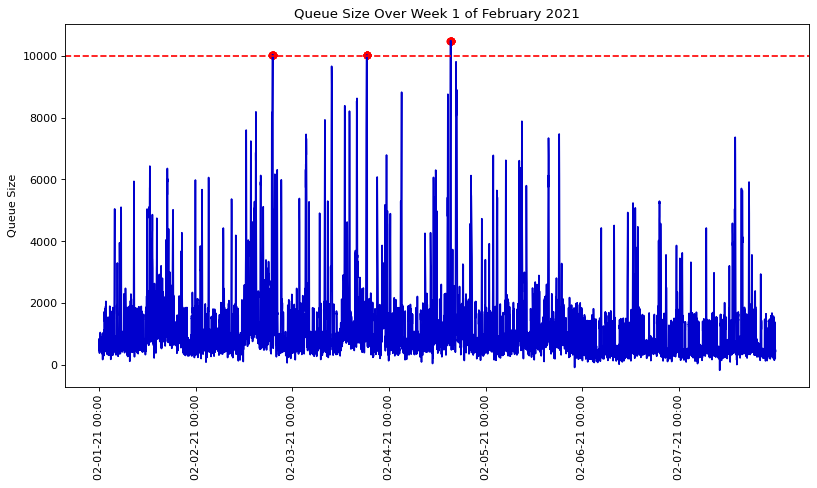

In [795]:
y = np.array(df_sim_week_1['Req_Queue'])
x = np.arange(len(df_sim_week_1["time"]))

plt.figure(figsize=(12, 6), dpi=80)
plt.plot(df_sim_week_1["time"], df_sim_week_1['Req_Queue'], color='mediumblue')
plt.xticks(df_sim_week_1["time"][::1440], rotation='vertical')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Week 1 of February 2021')

under_thres = y < QUEUE_CAP
over_thres = np.logical_not(under_thres)

plt.axhline(QUEUE_CAP, color='red', linestyle='--')
plt.scatter(x[over_thres], y[over_thres], color='red') 

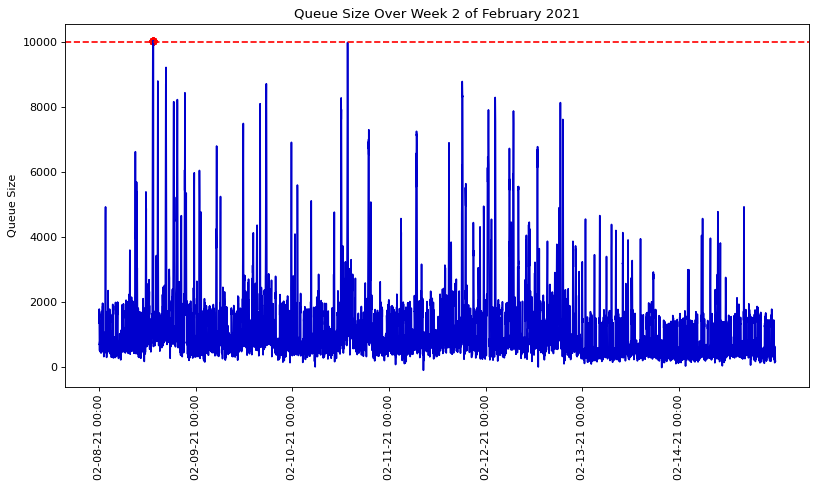

In [796]:
y = np.array(df_sim_week_2['Req_Queue'])
x = np.arange(len(df_sim_week_2["time"]))

plt.figure(figsize=(12, 6), dpi=80)
plt.plot(df_sim_week_2["time"], df_sim_week_2['Req_Queue'], color='mediumblue')
plt.xticks(df_sim_week_2["time"][::1440], rotation='vertical')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Week 2 of February 2021')

under_thres = y < QUEUE_CAP
over_thres = np.logical_not(under_thres)

plt.axhline(QUEUE_CAP, color='red', linestyle='--')
plt.scatter(x[over_thres], y[over_thres], color='red') 

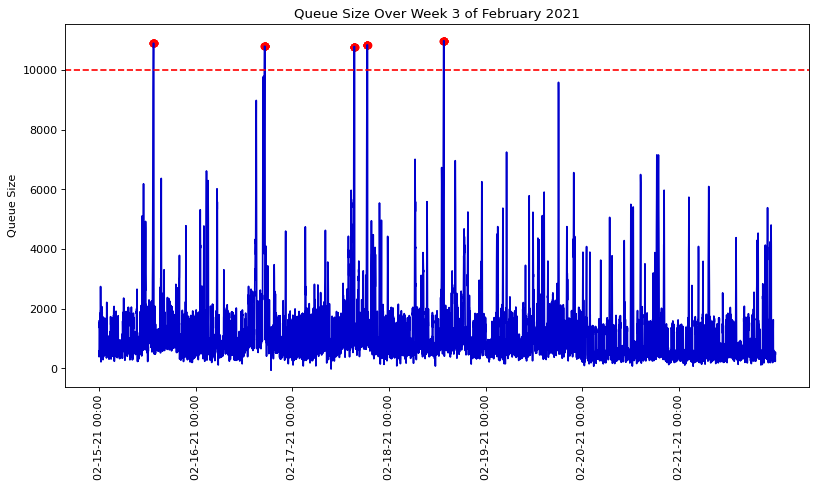

In [797]:
y = np.array(df_sim_week_3['Req_Queue'])
x = np.arange(len(df_sim_week_3["time"]))

plt.figure(figsize=(12, 6), dpi=80)
plt.plot(df_sim_week_3["time"], df_sim_week_3['Req_Queue'], color='mediumblue')
plt.xticks(df_sim_week_3["time"][::1440], rotation='vertical')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Week 3 of February 2021')

under_thres = y < QUEUE_CAP
over_thres = np.logical_not(under_thres)

plt.axhline(QUEUE_CAP, color='red', linestyle='--')
plt.scatter(x[over_thres], y[over_thres], color='red') 

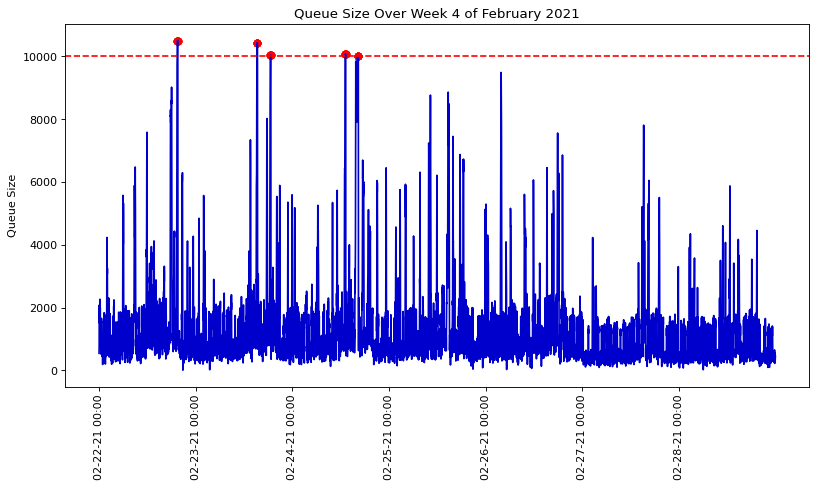

In [804]:
y = np.array(df_sim_week_4['Req_Queue'])
x = np.arange(len(df_sim_week_4["time"]))

plt.figure(figsize=(12, 6), dpi=80)
plt.plot(df_sim_week_4["time"], df_sim_week_4['Req_Queue'], color='mediumblue')
plt.xticks(df_sim_week_4["time"][::1440], rotation='vertical')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Week 4 of February 2021')

under_thres = y < QUEUE_CAP
over_thres = np.logical_not(under_thres)

plt.axhline(QUEUE_CAP, color='red', linestyle='--')
plt.scatter(x[over_thres], y[over_thres], color='red') 

## Visualize Distributions of Requests

In [ ]:
# Label weeks
df_sim_week_1["week"] = 1
df_sim_week_2["week"] = 2
df_sim_week_3["week"] = 3
df_sim_week_4["week"] = 4

In [ ]:
# Combine all weeks
df_feb = df_sim_week_1.append(df_sim_week_2)
df_feb = df_feb.append(df_sim_week_3)
df_feb = df_feb.append(df_sim_week_4)

<AxesSubplot:xlabel='week', ylabel='Req_Queue'>

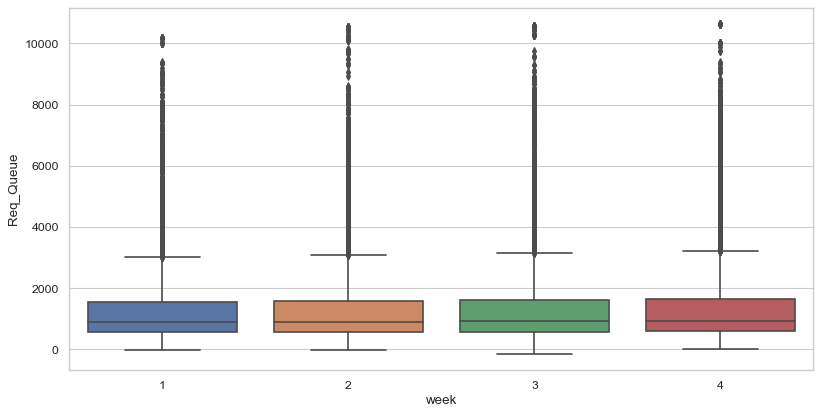

In [889]:
# Create box plot of request queue volume by week
plt.figure(figsize=(12, 6), dpi=80)
sns.boxplot(x="week", y="Req_Queue", data=df_feb)

<AxesSubplot:xlabel='week', ylabel='Req_Mod'>

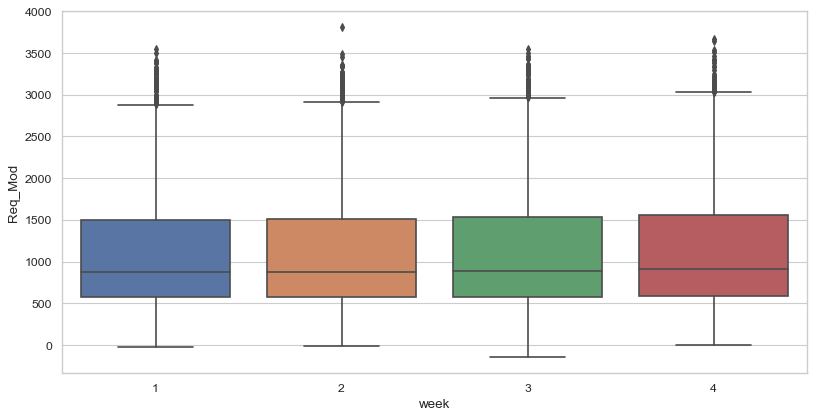

In [890]:
# Create box plot of per minute request volume by week
plt.figure(figsize=(12, 6), dpi=80)
sns.boxplot(x="week", y="Req_Mod", data=df_feb)

## Calculate Total Downtime for February

In [892]:
feb_downtime_mins = sum(df_sim_week_1["Downtime_Min"]) + sum(df_sim_week_2["Downtime_Min"]) + \
                    sum(df_sim_week_3["Downtime_Min"]) + sum(df_sim_week_4["Downtime_Min"])

print("Total February Downtime: ", 1 - (feb_downtime_mins / (1440 * 7 * 4)))

Total February Downtime:  0.9972718253968254


## Validation + Verification

The validation process was performed using actual website analytics and uptime data. The time of day and day of week multipliers were based on 12 months of historical seasonality via Google Analytics. The probability of bot attacks and expected requests per minute were determined from 3 months of site logs. Marketing campaigns for the organization this simulation is based on typically run over multiple months. Instead, I converted the portion marketing campaigns are live over the course of the year to a proportional amount of time they would be live over the course of a week. Put another way, if marketing campaigns are usually active for 30% of the year, the simulation would show them as active 30% of the week.

The first step in verification was ensuring the dataframes that capture each minute of the simulation have the expected amount of rows (10,080 - number of minutes in a week). Next, I checked the bot attacks and press events were occurring at the rate specified and that each of these events would last for the amount of minutes indicated. Further, I confirmed the modification to the baseline requests per minute were properly being adjusted based on the combination of multipliers and additional static requests. Lastly, verified all of the counters were being reset at the proper time, with the exception of “i” which was not resetting as intended.

## Conclusions + Findings

The simulation was run over four weeks resulting in an aggregate uptime of 99.7%.  This gap from the goal of 99.9% may seem small to those unfamiliar with the uptime expectations of enterprise websites, however, this is a significant discrepancy. For context, a 99.9% uptime in an average month would result in 43m 49s of downtime. 99.7% uptime would result in 2h 33m 24s, approximately a 200% increase in downtime. Due to zero weeks out of the four simulation runs reaching 99.9% and the impact this extra downtime will have on the organization's revenue, the recommendation would be to immediately implement a web farm. This would allow website requests to be distributed to multiple servers able to handle the volume of requests the website currently receives.